<a href="https://colab.research.google.com/github/joddle/SD_homeless_project/blob/master/sd_homeless_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install geopandas 
!pip install ipyleaflet
!pip install git+https://github.com/python-visualization/folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shapely
import shapely.wkt
import random
import folium
from folium.plugins import HeatMap 
from folium.plugins import MarkerCluster
from google.colab import widgets
from google.colab import files
from shapely import geometry
from shapely.geometry import Point, Polygon
from math import sqrt, asin, sin, cos, atan2, radians, degrees

     |████████████████████████████████| 921kB 10.0MB/s 
     |████████████████████████████████| 11.9MB 45.0MB/s 
     |████████████████████████████████| 10.1MB 45.9MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=458251eb0fa85c8c2ec588b058e0d0582d1407a66ebdcaef5e0157d717fb294c
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
     |████████████████████████████████| 2.2MB 9.2MB/s 
  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-77xlyn58
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-77xlyn58
  Created wheel for folium: filename=folium-0.10.0+2.g60ae79c-py2.py3-none-any.whl size=91399 sha256=75b012720824a6ae98e9cc0a06072b00c1f526508968af7d0404746d6fcf3ea1
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ovsivsm/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Succes

In [0]:
# Importing relevant data files from SD_homeless_project repository: https://github.com/joddle/SD_homeless_project
# ... using pandas to import as dataframe, and converting to geopandas dataframe

# Homeless counts data originally downloaded from: http://library.metatab.org/sandiegodata.org-dowtown_homeless-1.csv
# homeless_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-1/data/homeless_counts.csv?raw=true')
# homeless_df = gpd.GeoDataFrame(homeless_df, crs={'init':'epsg:4326'})

homeless_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-8/data/homeless_counts.csv?raw=true')
homeless_df = gpd.GeoDataFrame(homeless_df, crs={'init':'epsg:4326'})

# MTS stop locations data originally downloaded from: https://www.sdmts.com/google_transit_files/google_transit.zip
mts_stops_df = pd.read_csv('https://raw.githubusercontent.com/joddle/SD_homeless_project/master/google_transit/stops.txt')
mts_stops_df = gpd.GeoDataFrame(mts_stops_df, crs={'init':'epsg:4326'}, geometry=gpd.points_from_xy(mts_stops_df.stop_lon, mts_stops_df.stop_lat))

# imputed homeless counts data originally downloaded from: http://library.metatab.org/sandiegodata.org-dowtown_homeless-8.csv
homeless_imputed_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-8/data/imputed_counts.csv?raw=true')
homeless_imputed_df = gpd.GeoDataFrame(homeless_imputed_df, crs={'init':'epsg:4326'})

In [0]:
# homeless_df.head()

In [0]:
# Data visualizations: Missing Data 
# a large percentage of temperature and rain data is missing 
homeless_df.info()

In [0]:
homeless_imputed_df.head()
homeless_imputed_df.info()

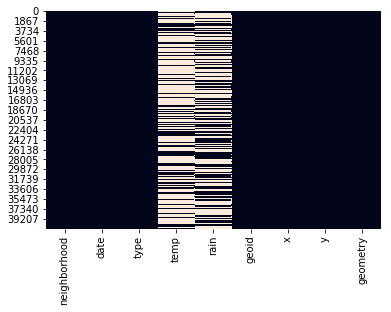

In [0]:
sns.heatmap(homeless_df.isnull(), cbar=False)

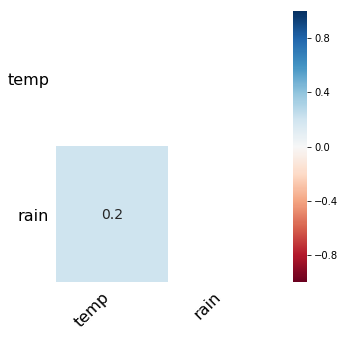

In [0]:
# determine if the location of missing values has correlation with any other variables
fig, ax = plt.subplots(figsize=(5,5))
msno.heatmap(homeless_df, ax=ax)

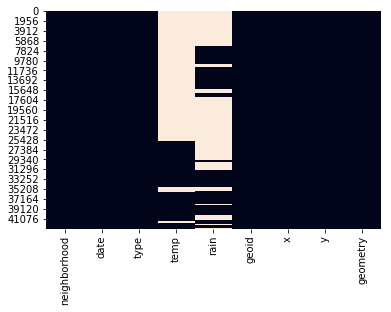

In [0]:
sns.heatmap(homeless_imputed_df.isnull(), cbar=False)

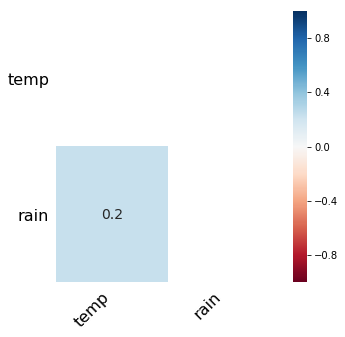

In [0]:
# determine if the location of missing values has correlation with any other variables
fig, ax = plt.subplots(figsize=(5,5))
msno.heatmap(homeless_imputed_df, ax=ax)

In [9]:
mts_stops_df = mts_stops_df[['stop_lon', 'stop_lat', 'geometry']]
# mts_stops_df.info()
# mts_stops_df.head()

# created a square polygon manually from http://apps.headwallphotonics.com/
# to encompass downtown SD approximately (an exact polygon would be ideal)
downtown_sd_polygon = Polygon([[-117.14498519897461, 32.72772530667563],
                          [-117.14469100989061, 32.70399523704015],
                          [-117.1773066715117, 32.70385078849076],
                          [-117.1773066715117, 32.72775384006868]])
# type(downtown_sd_polygon)
# print(downtown_sd_polygon.wkt)
downtown_index = []
for i in range(len(mts_stops_df.index)):
  if downtown_sd_polygon.contains(mts_stops_df['geometry'][i]):
    downtown_index.append(i)
# print(downtown_index)
downtown_mts_stops_df = mts_stops_df.iloc[downtown_index].reset_index()
downtown_mts_stops_df.head()

index    stop_lon   stop_lat                     geometry
0     42 -117.166685  32.715569  POINT (-117.16668 32.71557)
1     44 -117.164952  32.715598  POINT (-117.16495 32.71560)
2     48 -117.162107  32.715614  POINT (-117.16211 32.71561)
3     50 -117.160297  32.715660  POINT (-117.16030 32.71566)
4     52 -117.159474  32.715664  POINT (-117.15947 32.71566)

In [0]:
# this function takes in a dataframe with a 'geometry' feature, extracts the latitude and longitude, 
# and outputs a df with ['lat', 'lon']  features as well as an array of ['lat', 'lon'] values 
# that can be parsed by the folium library to generate heatmaps
def getLatLonforHeatMap(homeless_df):
  homeless_polygon = homeless_df['geometry']
  homeless_polygon_list = []
  # polygon coordinates are strings and need to be parsed
  # convert str into polygon type and then find centroid of this polygon as a point
  for polygon in homeless_polygon:
    homeless_polygon_list.append(shapely.wkt.loads(polygon))
  homeless_points = [polygon.centroid for polygon in homeless_polygon_list]
  homeless_lat_lon = pd.DataFrame({'lon':[point.x for point in homeless_points], 'lat':[point.y for point in homeless_points]})
  homeless_array = homeless_lat_lon[['lat', 'lon']].values
  return homeless_lat_lon, homeless_array

In [0]:
# Get lat/lon coordinates of homeless data
# homeless_polygon = homeless_df['geometry']
# type(homeless_polygon[0])

In [0]:
# polygon coordinates are strings and need to be parsed
# P = homeless_polygon[0]
# type(P)

In [0]:
# example: I want to convert a str into a polygon type
# ... and then find centroid of this polygon as a point
# P = shapely.wkt.loads('POLYGON ((51.0 3.0, 51.3 3.61, 51.3 3.0, 51.0 3.0))')
# print(P.centroid)

In [0]:
# type(homeless_polygon_list[0])

In [0]:
# Create map object with reference points
def make_ref_points_basemap(ref_points_df = downtown_mts_stops_df, default_loc = [32.7173, -117.1694], default_tiles = 'stamentoner', default_zoom = 13):
  ref_points_basemap = folium.Map(location = default_loc, tiles = default_tiles, zoom_start = default_zoom, control_scale = True)
  # add markers for the mts stations 
  for index, row in ref_points_df.iterrows():
    folium.CircleMarker([row['stop_lat'], row['stop_lon']],
                      radius = 1,
                      color = 'red',
                      fill_color = 'red',
                      ).add_to(ref_points_basemap)
  return ref_points_basemap

In [12]:
homeless_heatmap = make_ref_points_basemap()

# add the heatmap using the homeless array of lat/lon
# folium seems to have difficulty creating heatmaps for more than ~35,000 points

random.seed(42)
homeless_lat_lon_df, homeless_array = getLatLonforHeatMap(homeless_df)
homeless_array_subset = homeless_array[random.sample(range(0,len(homeless_array)), 35000)]

# heatmap = HeatMap(homeless_array).add_to(m)
homeless_heatmap.add_child(HeatMap(homeless_array_subset, radius=5))

# display heatmap
homeless_heatmap

In [13]:
homeless_imputed_heatmap = make_ref_points_basemap()

# add the heatmap using the homeless array of lat/lon
# folium seems to have difficulty creating heatmaps for more than ~30,000 points

random.seed(42)
homeless_imputed_lat_lon_df, homeless_imputed_array = getLatLonforHeatMap(homeless_df)
homeless_imputed_array_subset = homeless_imputed_array[random.sample(range(0,len(homeless_imputed_array)), 35000)]

homeless_imputed_heatmap.add_child(HeatMap(homeless_imputed_array_subset, radius=5))

# display heatmap
homeless_imputed_heatmap

In [0]:
downtown_mts_stops_df.head()

index    stop_lon   stop_lat                     geometry
0     42 -117.166685  32.715569  POINT (-117.16668 32.71557)
1     44 -117.164952  32.715598  POINT (-117.16495 32.71560)
2     48 -117.162107  32.715614  POINT (-117.16211 32.71561)
3     50 -117.160297  32.715660  POINT (-117.16030 32.71566)
4     52 -117.159474  32.715664  POINT (-117.15947 32.71566)

In [0]:
homeless_df.head()

In [0]:
# given a starting latitude and longitude, bearing angle (in units of DEGREES),
# as well as distance (in units of METERS)
# this function generates the ending latitude and longitude (in degrees)
# using the following formula (which has input and output in units of RADIANS)
# φ2 = asin(sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
# λ2 = λ1 + atan2(sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2)
# where	φ is latitude, λ is longitude, θ is the bearing (clockwise from north), 
# δ is the angular distance d/R; d being the distance travelled, R the earth’s radius
# Reference: https://www.movable-type.co.uk/scripts/latlong.html

# are negative distances a problem?
# absolute value of distance should solve this problem if necessary
def generateNewPoint(lat1, lon1, distance, bearing):
  lat1 = radians(lat1)
  lon1 = radians(lon1)
  bearing = radians(bearing)
  radius_Earth = 6.371*pow(10,6)
  angular_dist = distance / radius_Earth
  lat2 = asin(sin(lat1) * cos(angular_dist) + cos(lat1) * sin(angular_dist) * cos(bearing))
  lon2 = lon1 + atan2(sin(bearing) * sin(angular_dist) * cos(lon1), cos(angular_dist) - sin(lat1) * sin(lat2))
  return degrees(lat2), degrees(lon2)
  

In [91]:
# Note: mercator projection is distorted which is why a sequence of points the same distance from the starting point appear to form an ellipse
testmap = make_ref_points_basemap(default_zoom = 16)
lat_start, lon_start = downtown_mts_stops_df['stop_lat'][0], downtown_mts_stops_df['stop_lon'][0]
folium.CircleMarker([lat_start, lon_start],
                      radius = 1,
                      color = 'blue',
                      fill_color = 'blue',
                      ).add_to(testmap)
for bearing in range(0, 360, 4):
  lat_end, lon_end = generateNewPoint(lat_start, lon_start, 400, bearing)
  folium.CircleMarker([lat_end, lon_end],
                      radius = 1,
                      color = 'green',
                      fill_color = 'green',
                      ).add_to(testmap)
testmap


In [0]:
# this function takes in a ref_points_df that more points are to be generated around
# in the MTS stops research, we will generate points with radii normally distributed around each MTS stop
# ... there will be an argument to check whether each point is within the border of interest (in this case downtown SD)

# since the normal distribution represents the distance from the center of each stop
# it should be centered at 0 with a standard deviation that contains most of the data

# taking a 5-minute walk from each bus stop to be approximately 400 meters, 
# we expect 400 meters to be the distance most homeless people would be from each stop
# therefore we set 400 meters = 2 standard deviations or 95% of the observed data points, making the std_dev = 200

# the argument upper_distance will be 2 standard deviations so sigma = max_distance / 2
def get_simulated_points(ref_points_df = downtown_mts_stops_df, border = None, simulations_per_point = 10, upper_dist = 400):
  mu, sigma = 0, upper_dist / 2.0
  lats_list = []
  lons_list = []
  random.seed(411)
  for index, row in ref_points_df.iterrows():
    radii_rand = np.random.normal(mu, sigma, simulations_per_point)
    bearings_rand = 360.0 * np.random.ranf(simulations_per_point)
    for j in range(simulations_per_point):
      lat_new, lon_new = generateNewPoint(row['stop_lat'], row['stop_lon'], radii_rand[j], bearings_rand[j])
      lats_list.append(lat_new)
      lons_list.append(lon_new)
  return pd.DataFrame({'lat': lats_list, 'lon': lons_list})

In [17]:
simulated_points_df = get_simulated_points(ref_points_df = downtown_mts_stops_df, border = None, simulations_per_point = 200, upper_dist = 400)
simulated_points_array = simulated_points_df[['lat', 'lon']].values
simulated_points_heatmap = make_ref_points_basemap()
simulated_points_heatmap.add_child(HeatMap(simulated_points_array, radius = 5))

In [0]:
# in order to do statistical signifance testing we need a metric of spread of the data
# we will run a number of simulations and plot a histogram of the ANN (average nearest neighbors) value
# 
# Reference: https://mgimond.github.io/Spatial/hypothesis-testing.html#alternatives-to-csrirp

# helper functions for calculating haversine distance between two points (lat1, lat2), (lon1, lon2)
def haversine(angle_radians):
  return (sin(angle_radians / 2))**2
def get_haversine_dist(lat1, lon1, lat2, lon2):
  lat1, lat2 = radians(lat1), radians(lat2)
  lon1, lon2 = radians(lon1), radians(lon2)
  radius_earth = 6.371*pow(10,6)
  return 2*radius_earth*asin(sqrt(haversine(lat2 - lat1) + cos(lat1)*cos(lat2)*haversine(lon2 - lon1)))

In [0]:
# get_haversine_dist(36.12, -86.67, 33.94, -118.40)
# generateNewPoint(36.12, -86.67, 10, 180)
# get_haversine_dist(36.12, -86.67, 36.119910067839406, -86.67)
# should come out to approximately 10 meters 

In [0]:
# the following function takes a df of points and calculates the average nearest neighbors 
# from the df of points to each of the points in the df ref_pts (mts stops in this case)
# ... this metric is given by the average of the haversine distances between each observation and all reference points
# ANN ratio = D(O) / D(E) where D(O) is the mean of the sum of distances between each feature and its nearest neighbor
# ... and D(E) is the expected mean distance for features given by 0.5 / sqrt(n/A) 
# where n is the total number of features and A is the area of the minimum enclosing rectangle around the points
def get_ANN(points_df, ref_points_df):
  sum_NN = 0
  for one_index, one_row in points_df.iterrows():
    for other_index, other_row in ref_points_df.iterrows():
      sum_NN = sum_NN + get_haversine_dist(one_row['lat'], one_row['lon'], other_row['stop_lat'], other_row['stop_lon'])
    # print('Calculated ANN for point', one_index, 'of', len(points_df.index))
  mean_dist_obs = sum_NN / len(points_df.index)
  return mean_dist_obs / sqrt(len(points_df.index))

In [0]:
def get_simulated_ANNs(ref_points_df, number_of_cycles = 100, points_per_ref = 5):
  simulated_ANNs = []
  for cycle in range(number_of_cycles):
    simulated_points_df = get_simulated_points(ref_points_df = ref_points_df, border = None, simulations_per_point = points_per_ref, upper_dist = 400)
    simulated_ANNs.append(get_ANN(simulated_points_df, ref_points_df))
    print('finished simulation', cycle+1)
  return simulated_ANNs

In [0]:
simulated_ANNs = get_simulated_ANNs(ref_points_df = downtown_mts_stops_df, number_of_cycles = 100, points_per_ref = 30)

In [0]:
def plot_simulation_histogram(simulated_points_list):
  simulated_points_array = np.asarray(simulated_points_list)
  plt.hist(simulated_points_array)
  plt.title('Histogram of ANN for simulated homeless around mts stops')
  plt.xlabel('ANN')
  plt.ylabel('Count')
  plt.show()

In [0]:
# simulated_ANNs_df = pd.DataFrame({'ANNs': simulated_ANNs})
# simulated_ANNs_df.to_csv('simulated_ANNs.csv')
# files.download('simulated_ANNs.csv')

In [31]:
# reupload the simulated_ANNs
simulated_points_list = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/simulated_ANNs.csv?raw=true')
simulated_points_list.head()

Unnamed: 0         ANNs
0           0  2642.925836
1           1  2639.435419
2           2  2642.477109
3           3  2642.339694
4           4  2639.347362

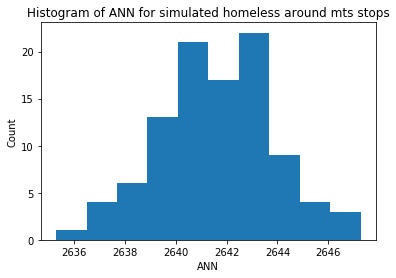

In [32]:
plot_simulation_histogram(simulated_points_list['ANNs'])

In [0]:
blocks_df = pd.read_csv('http://library.metatab.org/sandiegodata.org-pedestrian-blocks-1/data/blocks.csv')

In [66]:
len(simulated_points_df)

31800

In [0]:
observed_ANN = get_ANN(homeless_lat_lon_df, downtown_mts_stops_df)

In [73]:
## observed_ANN = 893.276 which is MUCH lower than any of the simulated ANN values 
## which indicates that the observed homeless population is 
## substantially more clustered around mts stops than the simulated data points... this result is a little hard to believe
observed_ANN

893.2761548473945

In [33]:
## Ground False Analysis: the extremely closely clustered data points should definitely *not* be similar to the observed data
close_simulated_points_df = get_simulated_points(ref_points_df = downtown_mts_stops_df, border = None, simulations_per_point = 300, upper_dist = 40)
close_simulated_points_array = simulated_points_df[['lat', 'lon']].values
close_simulated_points_heatmap = make_ref_points_basemap()
close_simulated_points_heatmap.add_child(HeatMap(close_simulated_points_array, radius = 6))

In [34]:
close_simulated_ANNs = get_simulated_ANNs(ref_points_df = downtown_mts_stops_df, number_of_cycles = 50, points_per_ref = 50)

finished simulation 1
finished simulation 2
finished simulation 3
finished simulation 4
finished simulation 5
finished simulation 6
finished simulation 7
finished simulation 8
finished simulation 9
finished simulation 10
finished simulation 11
finished simulation 12
finished simulation 13
finished simulation 14
finished simulation 15
finished simulation 16
finished simulation 17
finished simulation 18
finished simulation 19
finished simulation 20
finished simulation 21
finished simulation 22
finished simulation 23
finished simulation 24
finished simulation 25
finished simulation 26
finished simulation 27
finished simulation 28
finished simulation 29
finished simulation 30
finished simulation 31
finished simulation 32
finished simulation 33
finished simulation 34
finished simulation 35
finished simulation 36
finished simulation 37
finished simulation 38
finished simulation 39
finished simulation 40
finished simulation 41
finished simulation 42
finished simulation 43
finished simulation 

In [35]:
close_simulated_ANNs

[2048.1409539815854,
 2046.0201045859058,
 2046.167719663148,
 2047.1822694652492,
 2045.4755548474154,
 2047.6982233736035,
 2046.8643089227721,
 2047.2175686956432,
 2045.1797050581697,
 2048.4757572238514,
 2043.2143408653287,
 2045.0399803288722,
 2044.3178879625636,
 2047.7264282276337,
 2046.6259288075753,
 2044.5706175422235,
 2047.2259017492775,
 2047.2686757454178,
 2045.8311105449409,
 2043.5170771963617,
 2045.2255693209654,
 2047.352428911016,
 2045.660413082216,
 2046.5762140078605,
 2043.9258869780974,
 2046.3072006845427,
 2043.5459097075502,
 2042.4309621808666,
 2046.6699120015353,
 2046.4083170279825,
 2049.416911952864,
 2047.667372021223,
 2045.287466052928,
 2045.6227181386657,
 2047.9747925209863,
 2046.525688572957,
 2046.296336676166,
 2048.4641965432,
 2046.1966506420972,
 2048.466297093994,
 2046.627053079515,
 2046.508093703393,
 2045.0237130609376,
 2046.7921325974962,
 2044.6680021689492,
 2047.4416015276051,
 2046.378771731268,
 2045.9934700917913,
 2045.1

In [38]:
plot_simulation_histogram(close_simulated_ANNs['ANNs'])

TypeError: ignored